# Fig 2-3: Analysis of lineage level growth statistics and cell-size control

This notebook does the analysis presented in section 1 of the paper, which concerns the relative contributions of growth rate and generation time variation to size control. 

# Setup

In [6]:
using CSV,DataFrames,Distributions,StatsBase,PythonPlot,LinearAlgebra

## Load experimental data

In [7]:
df_all = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
df_all  = df_all[df_all.length .>= 5,:]
lineages = unique(df_all.lineage);


df_all_cells = combine(groupby(df_all,[:lineage,:position]),
    [:time,:lnM]=>((x,y)-> (y[end]-y[1])/(x[end]-x[1]))=>:gr, 
    [:time,:lnM]=>((x,y)-> cov(x .- x[1],y .- y[1])/var(x .- x[1]))=>:gr_lr,
    :M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf,
    :time=>(x->x[end]-x[1])=>:gt,
    :length=>(x->x[1])=>:length)


df_all_cells[:,:y] = vcat([log.(df.Mf ./ df.M0) for df in groupby(df_all_cells,:lineage)]...)
df_all_cells[:,:x] = vcat([log.(df.M0 ./ mean(df.M0)) for df in groupby(df_all_cells,:lineage)]...)


# correlation params
corrs = combine(groupby(df_all_cells, :lineage),
    [:x,:y]=>((x,y)-> -cov(x,y)/var(x))=>:α,
    [:x,:gr,:gt]=>((x,y,gt)-> -cov(x,y)/var(x)*mean(gt))=>:αλ,
    [:x,:gr_lr,:gt]=>((x,y,gt)-> -cov(x,y)/var(x)*mean(gt))=>:αλ_lr);

In [8]:
mean(corrs.αλ)



0.02397901372337777

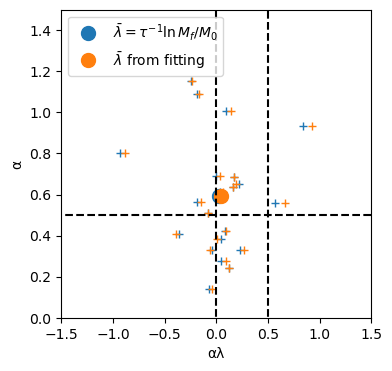

In [9]:
fig, ax= subplots(1,1,figsize=(4,4))
ax.plot(corrs.αλ,corrs.α,"C0+")
ax.plot([mean(corrs.αλ)],[mean(corrs.α)],"C0.",markersize=20,label=L"$\bar{\lambda} = \tau^{-1}\ln M_f/M_0$")

ax.plot(corrs.αλ_lr,corrs.α,"C1+")
ax.plot([mean(corrs.αλ_lr)],[mean(corrs.α)],"C1.",markersize=20,label=L"$\bar{\lambda}$ from fitting")
ax.vlines(0,-2,2,"k","--")
ax.vlines(0.5,-2,2,"k","--")
ax.hlines(0.5,-2,2,"k","--")
ax.legend(loc="upper left")
ax.set_xlim(-1.5,1.5)
ax.set_ylim(0,1.5)
ax.set_xlabel("αλ")
ax.set_ylabel("α")
fig

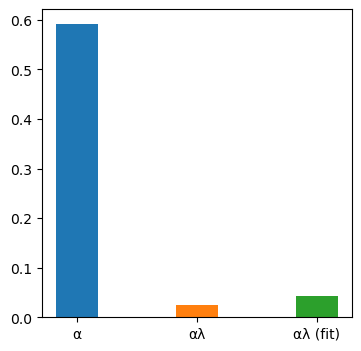

In [10]:
# bar chart of \alpha vs \alpha_{\lambda}
fig2, ax2 = subplots(1,1,figsize=(4,4))
width = 0.35
ax2.bar.(["α","αλ","αλ (fit)"],[mean(corrs.α),mean(corrs.αλ),mean(corrs.αλ_lr)],width)      
fig2

# Compare to older SMR data set

In [152]:
# Read the old SMR data with proper column names
# Format: chronological cell number, group/lineage number, time from abscission, 
# time from cytokinesis, size (raw), size (smoothed), growth rate
df_all_nm = CSV.read("/Users/elevien/Downloads/OldNatMethodspapergrowthdata/CurvesL1210_GOODcomplete.txt",
    DataFrames.DataFrame, 
    header=false,
    delim=' ',
    ignorerepeated=true);

# Assign meaningful column names based on the format description
rename!(df_all_nm, [:cell, :group_lineage, :time_abscission, :time_cytokinesis, :size_raw, :size_smooth, :growth_rate])

# Extract group and lineage information
df_all_nm.group = div.(df_all_nm.group_lineage, 100)  # First two digits
df_all_nm.lineage = mod.(df_all_nm.group_lineage, 100)  # Last two digits
df_all_nm.M = df_all_nm.size_smooth
df_all_nm.lnM = log.(df_all_nm.M)
df_all_nm.time = df_all_nm.time_abscission


df_all_nm_cells = combine(groupby(df_all_nm,[:group,:lineage,:cell]),
    [:time,:lnM]=>((x,y)-> (y[end]-y[1])/(x[end]-x[1]))=>:gr, 
    [:time,:lnM]=>((x,y)-> cov(x .- x[1],y .- y[1])/var(x .- x[1]))=>:gr_lr,
    :M=>(x->x[1])=>:M0,:M=>(x->x[end])=>:Mf,
    :time=>(x->x[end]-x[1])=>:gt)


df_all_nm_cells[:,:y] = log.(df_all_nm_cells.Mf ./ df_all_nm_cells.M0) #vcat([log.(df.Mf ./ df.M0) for df in groupby(df_all_nm_cells,:lineage)]...)
df_all_nm_cells[:,:x] = log.(df_all_nm_cells.M0 ./ mean(df_all_nm_cells.M0)) # vcat([log.(df.M0 ./ mean(df.M0)) for df in groupby(df_all_nm_cells,:lineage)]...)
df_all_nm_cells = df_all_nm_cells[2:end,:]

# Correlation params - FIXED to match original definition
α = -cov(df_all_nm_cells.x,df_all_nm_cells.y)/var(df_all_nm_cells.x)

# CORRECTED: Use same definition as original dataset
# Original: -cov(x,gr)/var(x)*mean(gt)
αλ = -cov(df_all_nm_cells.x, df_all_nm_cells.gr)/var(df_all_nm_cells.x)*mean(df_all_nm_cells.gt)

0.3375599864732088

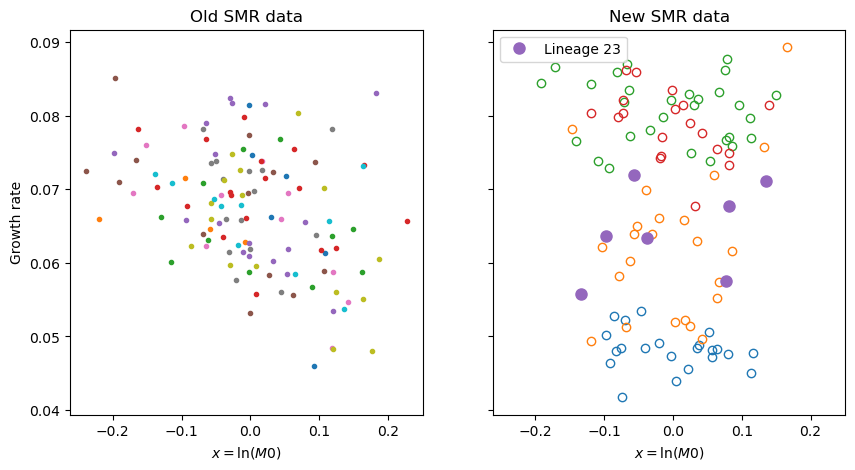

In [158]:
fig,axs = subplots(figsize=(10,5),ncols=2,sharex=true,sharey=true)
lineages = unique(df_all_nm_cells.lineage)
groups = unique(df_all_nm_cells.group)

ax = axs[0]
for group in groups
    d_group = df_all_nm_cells[df_all_nm_cells.group .== group,:]  # Fixed: use 'group' not 'groups'
    ax.plot(d_group.x, d_group.gr, ".")
end


ax = axs[1]
for l in unique(df_all_cells.lineage)
    df = df_all_cells[df_all_cells.lineage .== l,:]
    if df.length[1] >15
        ax.plot(df.x, df.gr, "o",fillstyle="none")
    end
end

df = df_all_cells[df_all_cells.lineage .==23,:]
ax.plot(df.x, df.gr, "o",markersize=8,label="Lineage 23")

axs[1].set_xlabel(L"$x = \ln(M0)$")
axs[0].set_xlabel(L"$x = \ln(M0)$")
axs[0].set_ylabel("Growth rate")
axs[0].set_title("Old SMR data")
axs[1].set_title("New SMR data")
axs[1].legend()
fig